<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Natural Language Processing For Everyone</h1>
        <h1>Text Representation</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In this lesson we will see in some details how we can best represent text in our application. Let's start by importing the modules we will be using:

In [1]:
import string
from collections import Counter
from pprint import pprint
import gzip

import matplotlib
import matplotlib.pyplot as plt 
import numpy as np

import watermark

%matplotlib inline
%load_ext watermark

List out the versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: ed7010f27131287f28d990d9846e4ce6cd87e34d

numpy     : 1.26.4
matplotlib: 3.8.0
watermark : 2.4.3



Set the default style

In [3]:
plt.style.use('d4sci.mplstyle')

We choose a well known nursery rhyme, that has the added distinction of having been the first audio ever recorded, to be the short snippet of text that we will use in our examples:

In [4]:
text = """Mary had a little lamb, little lamb,
    little lamb. 'Mary' had a little lamb
    whose fleece was white as snow.
    And everywhere that Mary went
    Mary went, MARY went. Everywhere
    that mary went,
    The lamb was sure to go"""

## Tokenization

The first step in any analysis is to tokenize the text. What this means is that we will extract all the individual words in the text. For the sake of simplicity, we will assume that our text is well formed and that our words are delimited either by white space or punctuation characters.

In [5]:
def extract_words(text):
    temp = text.split() # Split the text on whitespace
    text_words = []

    for word in temp:
        # Remove any punctuation characters present in the beginning of the word
        while word[0] in string.punctuation:
            word = word[1:]

        # Remove any punctuation characters present in the end of the word
        while word[-1] in string.punctuation:
            word = word[:-1]

        # Append this word into our list of words.
        text_words.append(word.lower())
        
    return text_words

In [6]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


After this step we now have our text represented as an array of individual, lowercase, words:

In [7]:
text_words = extract_words(text)
print(text_words)

['mary', 'had', 'a', 'little', 'lamb', 'little', 'lamb', 'little', 'lamb', 'mary', 'had', 'a', 'little', 'lamb', 'whose', 'fleece', 'was', 'white', 'as', 'snow', 'and', 'everywhere', 'that', 'mary', 'went', 'mary', 'went', 'mary', 'went', 'everywhere', 'that', 'mary', 'went', 'the', 'lamb', 'was', 'sure', 'to', 'go']


As we saw during the video, this is a wasteful way to represent text. We can be much more efficient by representing each word by a number

In [8]:
word_dict = {}
word_list = []
vocabulary_size = 0
text_tokens = []

for word in text_words:
    # If we are seeing this word for the first time, create an id for it and added it to our word dictionary
    if word not in word_dict:
        word_dict[word] = vocabulary_size
        word_list.append(word)
        vocabulary_size += 1
    
    # add the token corresponding to the current word to the tokenized text.
    text_tokens.append(word_dict[word])

When we were tokenizing our text, we also generated a dictionary **word_dict** that maps words to integers and a **word_list** that maps each integer to the corresponding word.

In [9]:
print("Word list:", word_list, "\n\n Word dictionary:")
pprint(word_dict)

Word list: ['mary', 'had', 'a', 'little', 'lamb', 'whose', 'fleece', 'was', 'white', 'as', 'snow', 'and', 'everywhere', 'that', 'went', 'the', 'sure', 'to', 'go'] 

 Word dictionary:
{'a': 2,
 'and': 11,
 'as': 9,
 'everywhere': 12,
 'fleece': 6,
 'go': 18,
 'had': 1,
 'lamb': 4,
 'little': 3,
 'mary': 0,
 'snow': 10,
 'sure': 16,
 'that': 13,
 'the': 15,
 'to': 17,
 'was': 7,
 'went': 14,
 'white': 8,
 'whose': 5}


These two datastructures already proved their usefulness when we converted our text to a list of tokens.

In [10]:
print(text_tokens)

[0, 1, 2, 3, 4, 3, 4, 3, 4, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 14, 0, 14, 0, 14, 12, 13, 0, 14, 15, 4, 7, 16, 17, 18]


Unfortunately, while this representation is convenient for memory reasons it has some severe limitations. Perhaps the most important of which is the fact that computers naturally assume that numbers can be operated on mathematically (by addition, subtraction, etc) in a way that doesn't match our understanding of words.

## One-hot encoding

One typical way of overcoming this difficulty is to represent each word by a one-hot encoded vector where every element is zero except the one corresponding to a specific word.

In [11]:
def one_hot(word, word_dict):
    """
        Generate a one-hot encoded vector corresponding to *word*
    """
    
    vector = np.zeros(len(word_dict))
    vector[word_dict[word]] = 1
    
    return vector

So, for example, the word "fleece" would be represented by:

In [12]:
fleece_hot = one_hot("fleece", word_dict)
print(fleece_hot)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


This vector has every element set to zero, except element 6, since:

In [13]:
print(word_dict["fleece"])
fleece_hot[6] == 1

6


True

In [14]:
print(fleece_hot.sum())

1.0


## Bag of words

We can now use the one-hot encoded vector for each word to produce a vector representation of our original text, by simply adding up all the one-hot encoded vectors:

In [15]:
text_vector1 = np.zeros(vocabulary_size)

for word in text_words:
    hot_word = one_hot(word, word_dict)
    text_vector1 += hot_word
    
print(text_vector1)

[6. 2. 2. 4. 5. 1. 1. 2. 1. 1. 1. 1. 2. 2. 4. 1. 1. 1. 1.]


In practice, we can also easily skip the encoding step at the word level by using the *word_dict* defined above:

In [16]:
text_vector = np.zeros(vocabulary_size)

for word in text_words:
    text_vector[word_dict[word]] += 1
    
print(text_vector)

[6. 2. 2. 4. 5. 1. 1. 2. 1. 1. 1. 1. 2. 2. 4. 1. 1. 1. 1.]


Naturally, this approach is completely equivalent to the previous one and has the added advantage of being more efficient in terms of both speed and memory requirements.

This is known as the __bag of words__ representation of the text. It should be noted that these vectors simply contains the number of times each word appears in our document, so we can easily tell that the word *mary* appears exactly 6 times in our little nursery rhyme.

In [17]:
text_vector[word_dict["mary"]]

6.0

A more pythonic (and efficient) way of producing the same result is to use the standard __Counter__ module:

In [18]:
word_counts = Counter(text_words)
pprint(word_counts)

Counter({'mary': 6,
         'lamb': 5,
         'little': 4,
         'went': 4,
         'had': 2,
         'a': 2,
         'was': 2,
         'everywhere': 2,
         'that': 2,
         'whose': 1,
         'fleece': 1,
         'white': 1,
         'as': 1,
         'snow': 1,
         'and': 1,
         'the': 1,
         'sure': 1,
         'to': 1,
         'go': 1})


From which we can easily generate the __text_vector__ and __word_dict__ data structures:

In [19]:
items = list(word_counts.items())

# Extract word dictionary and vector representation
word_dict2 = dict([[items[i][0], i] for i in range(len(items))])
text_vector2 = [items[i][1] for i in range(len(items))]

In [20]:
word_counts['mary']

6

And let's take a look at them:

In [21]:
text_vector

array([6., 2., 2., 4., 5., 1., 1., 2., 1., 1., 1., 1., 2., 2., 4., 1., 1.,
       1., 1.])

In [22]:
print("Text vector:", text_vector2, "\n\nWord dictionary:")
pprint(word_dict2)

Text vector: [6, 2, 2, 4, 5, 1, 1, 2, 1, 1, 1, 1, 2, 2, 4, 1, 1, 1, 1] 

Word dictionary:
{'a': 2,
 'and': 11,
 'as': 9,
 'everywhere': 12,
 'fleece': 6,
 'go': 18,
 'had': 1,
 'lamb': 4,
 'little': 3,
 'mary': 0,
 'snow': 10,
 'sure': 16,
 'that': 13,
 'the': 15,
 'to': 17,
 'was': 7,
 'went': 14,
 'white': 8,
 'whose': 5}


The results using this approach are slightly different than the previous ones, because the words are mapped to different integer ids but the corresponding values are the same:

In [23]:
for word in word_dict.keys():
    if text_vector[word_dict[word]] != text_vector2[word_dict2[word]]:
        print("Error!")

As expected, there are no differences!

## Term Frequency

The bag of words vector representation introduced above relies simply on the frequency of occurence of each word. Following a long tradition of giving fancy names to simple ideas, this is known as __Term Frequency__.

Intuitively, we expect the the frequency with which a given word is mentioned should correspond to the relevance of that word for the piece of text we are considering. For example, **Mary** is a pretty important word in our little nursery rhyme and indeed it is the one that occurs the most often:

In [24]:
items

[('mary', 6),
 ('had', 2),
 ('a', 2),
 ('little', 4),
 ('lamb', 5),
 ('whose', 1),
 ('fleece', 1),
 ('was', 2),
 ('white', 1),
 ('as', 1),
 ('snow', 1),
 ('and', 1),
 ('everywhere', 2),
 ('that', 2),
 ('went', 4),
 ('the', 1),
 ('sure', 1),
 ('to', 1),
 ('go', 1)]

In [25]:
sorted(items, key=lambda x: x[1], reverse=True)

[('mary', 6),
 ('lamb', 5),
 ('little', 4),
 ('went', 4),
 ('had', 2),
 ('a', 2),
 ('was', 2),
 ('everywhere', 2),
 ('that', 2),
 ('whose', 1),
 ('fleece', 1),
 ('white', 1),
 ('as', 1),
 ('snow', 1),
 ('and', 1),
 ('the', 1),
 ('sure', 1),
 ('to', 1),
 ('go', 1)]

However, it's hard to draw conclusions from such a small piece of text. Let us consider a significantly larger piece of text, the first 100 MB of the english Wikipedia from: http://mattmahoney.net/dc/textdata. For the sake of convenience, text8.gz has been included in this repository in the **data/** directory. We start by loading it's contents into memory as an array of words:

In [26]:
%%time
data = []

for line in gzip.open("data/text8.gz", 'rt'):
    data.extend(line.strip().split())

CPU times: user 626 ms, sys: 108 ms, total: 734 ms
Wall time: 734 ms


Now let's take a look at the first 50 words in this large corpus:

In [27]:
data[:50]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'is',
 'still',
 'used',
 'in',
 'a',
 'pejorative',
 'way',
 'to',
 'describe',
 'any',
 'act',
 'that',
 'used',
 'violent',
 'means',
 'to',
 'destroy',
 'the']

And the top 10 most common words

In [28]:
counts = Counter(data)

sorted_counts = sorted(list(counts.items()), key=lambda x: x[1], reverse=True)

for word, count in sorted_counts[:20]:
    print(word, count)

the 1061396
of 593677
and 416629
one 411764
in 372201
a 325873
to 316376
zero 264975
nine 250430
two 192644
is 183153
as 131815
eight 125285
for 118445
s 116710
five 115789
three 114775
was 112807
by 111831
that 109510


Surprisingly, we find that the most common words are not particularly meaningful. Indeed, this is a common occurence in Natural Language Processing. The most frequent words are typically auxiliaries required due to gramatical rules.

On the other hand, there is also a large number of words that occur very infrequently as can be easily seen by glancing at the word freqency distribution.

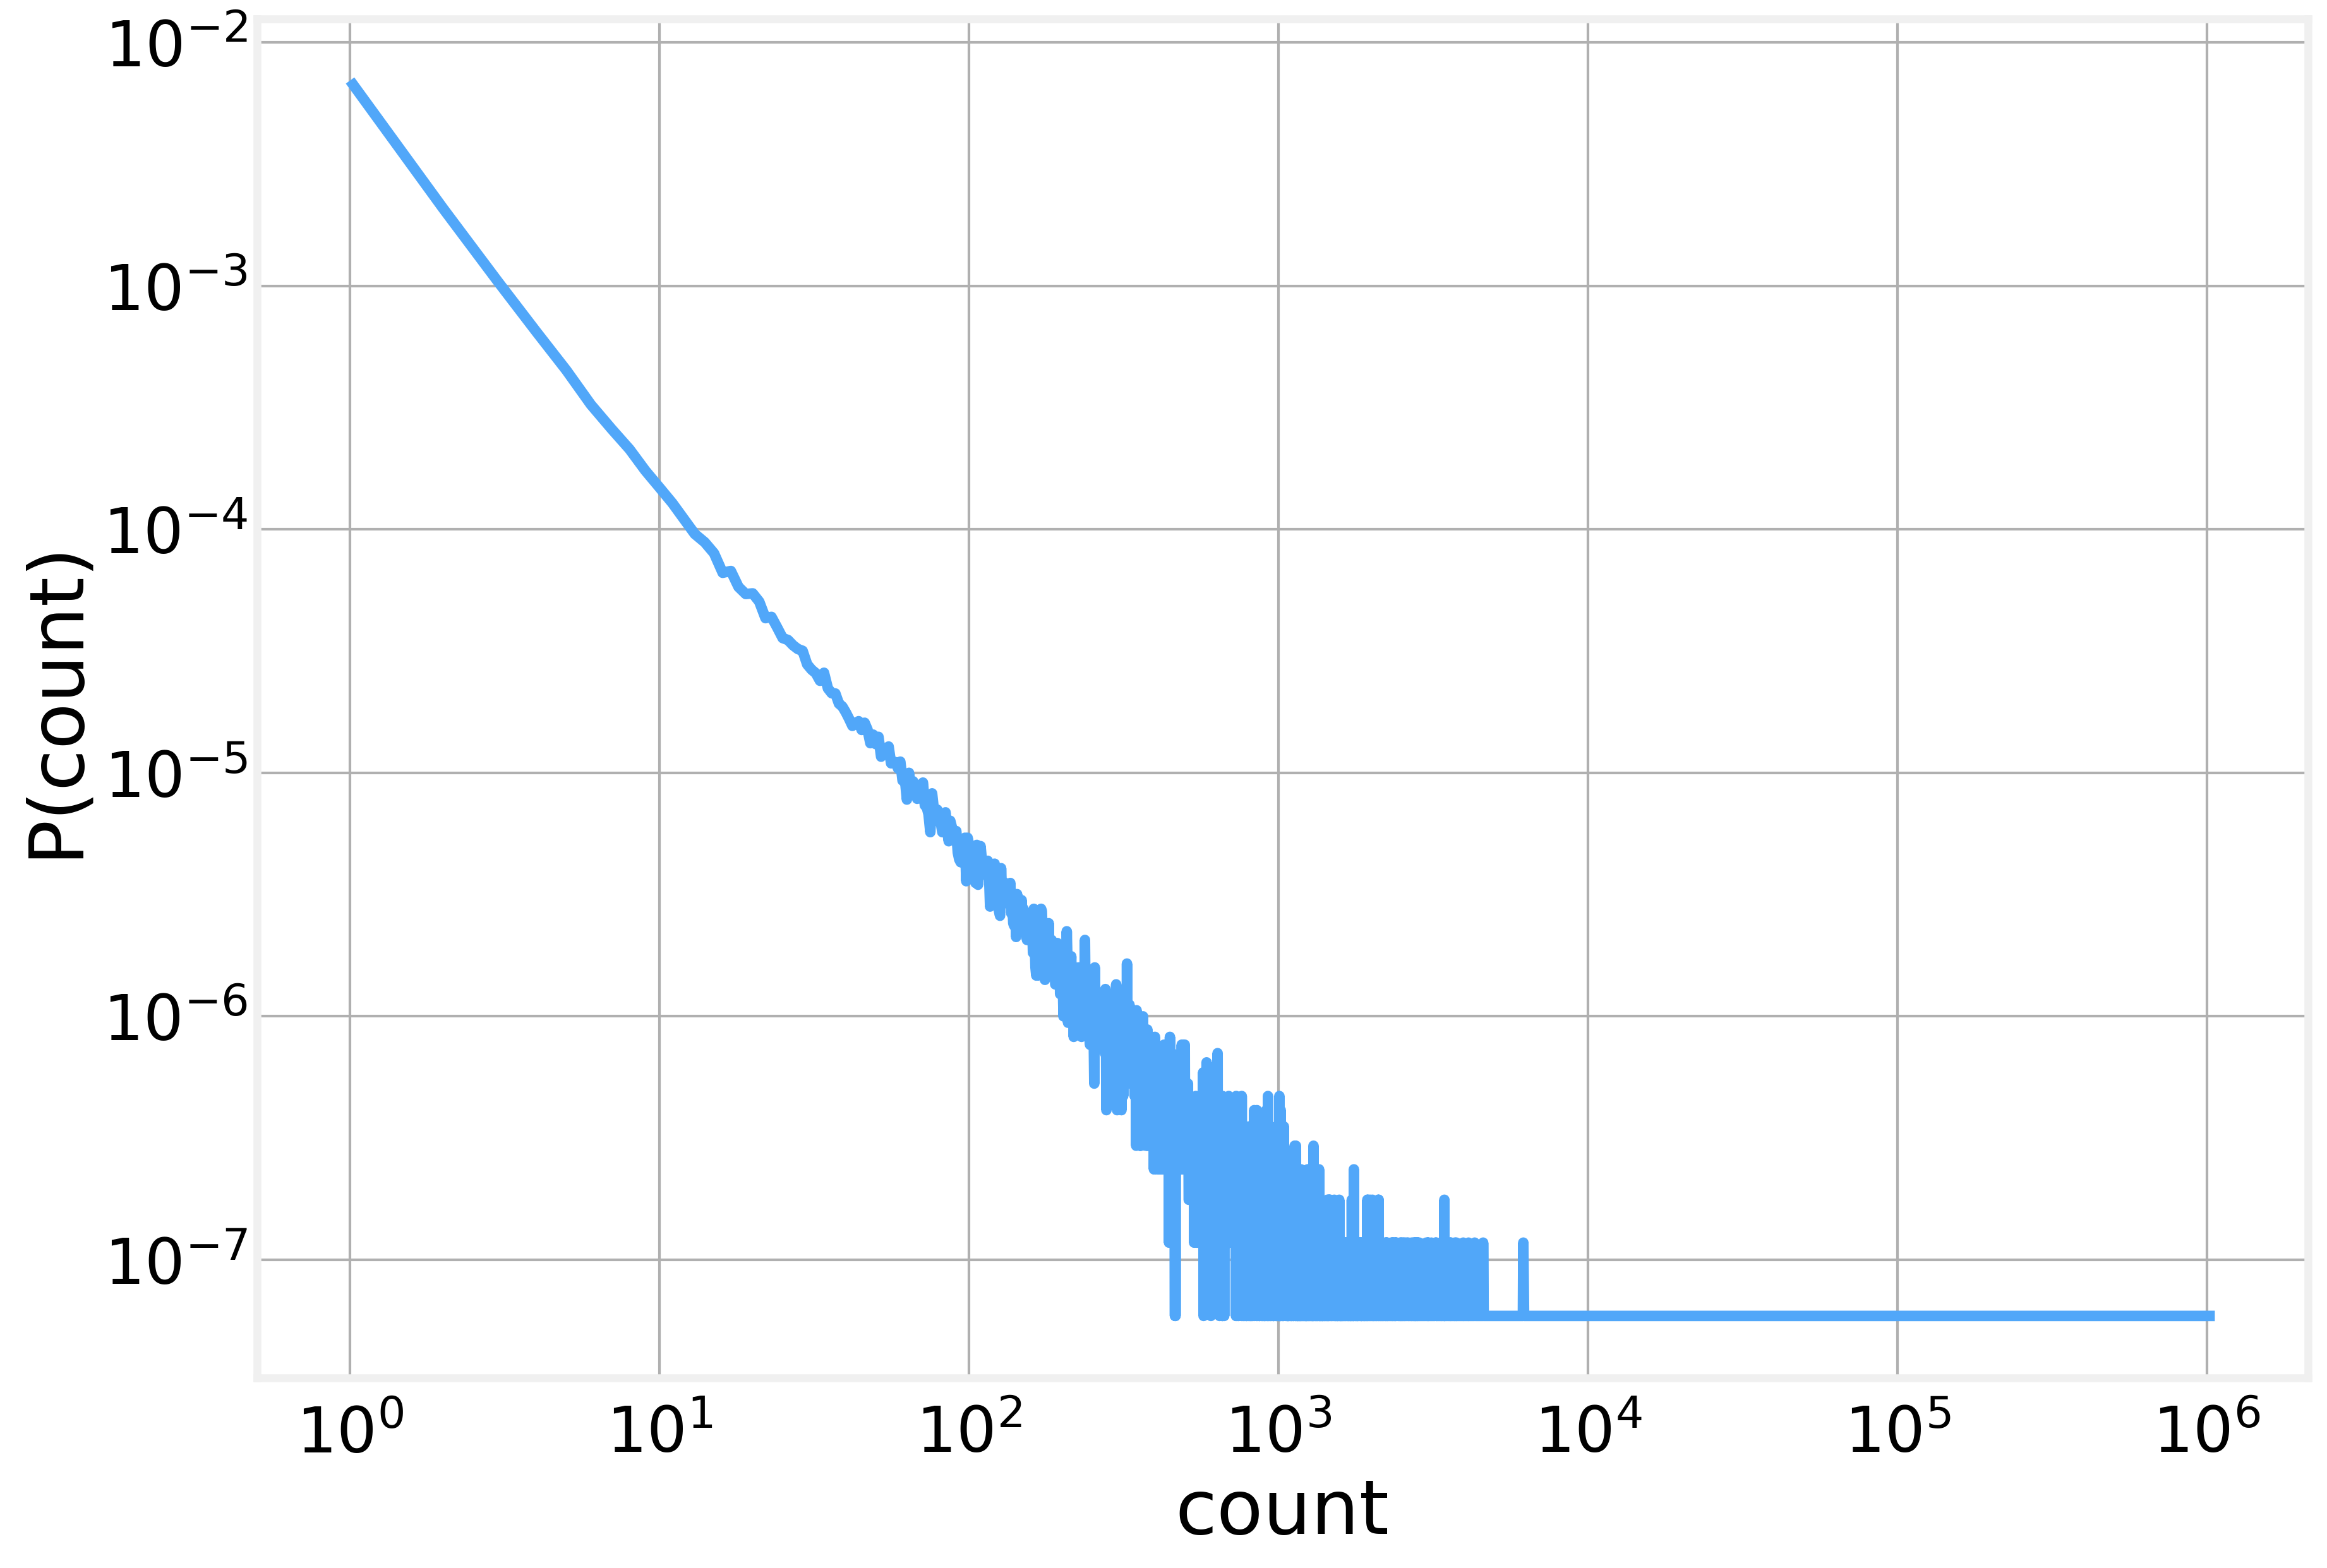

In [29]:
dist = Counter(counts.values())
dist = list(dist.items())
dist.sort(key=lambda x: x[0])
dist = np.array(dist)

norm = np.dot(dist.T[0], dist.T[1])

fig, ax = plt.subplots(1)
ax.loglog(dist.T[0], dist.T[1]/norm)
ax.set_xlabel("count")
ax.set_ylabel("P(count)")
ax.tick_params(axis="x",direction="out", pad=10)

## Stopwords

One common technique to simplify NLP tasks is to remove what are known as Stopwords, words that are very frequent but not meaningful. If we simply remove the most common 100 words, we significantly reduce the amount of data we have to consider while losing little information.

In [30]:
stopwords = set([word for word, count in sorted_counts[:100]])

clean_data = []

for word in data:
    if word not in stopwords:
        clean_data.append(word)

print("Original size:", len(data))
print("Clean size:", len(clean_data))
print("Reduction:", np.round(1-len(clean_data)/len(data), 2)*100)

Original size: 17005207
Clean size: 9006229
Reduction: 47.0


In [31]:
clean_data[:50]

['anarchism',
 'originated',
 'term',
 'abuse',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'diggers',
 'english',
 'revolution',
 'sans',
 'culottes',
 'french',
 'revolution',
 'whilst',
 'term',
 'still',
 'pejorative',
 'way',
 'describe',
 'any',
 'act',
 'violent',
 'means',
 'destroy',
 'organization',
 'society',
 'taken',
 'positive',
 'label',
 'self',
 'defined',
 'anarchists',
 'word',
 'anarchism',
 'derived',
 'greek',
 'without',
 'archons',
 'ruler',
 'chief',
 'king',
 'anarchism',
 'political',
 'philosophy',
 'belief',
 'rulers']

Wow, our dataset size was reduced almost in half!

In practice, we don't simply remove the most common words in our corpus but rather a manually curate list of stopwords. Lists for dozens of languages and applications can easily be found online.

## Term Frequency/Inverse Document Frequency

One way of determining of the relative importance of a word is to see how often it appears across multiple documents. Words that are relevant to a specific topic are more likely to appear in documents about that topic and much less in documents about other topics. On the other hand, less meaningful words (like **the**) will be common across documents about any subject.

To measure the document frequency of a word we will need to have multiple documents. For the sake of simplicity, we will treat each sentence of our nursery rhyme as an individual document:

In [32]:
print(text)

Mary had a little lamb, little lamb,
    little lamb. 'Mary' had a little lamb
    whose fleece was white as snow.
    And everywhere that Mary went
    Mary went, MARY went. Everywhere
    that mary went,
    The lamb was sure to go


In [33]:
corpus_text = text.split('.')
corpus_words = []

for document in corpus_text:
    doc_words = extract_words(document)
    corpus_words.append(doc_words)

Now our corpus is represented as a list of word lists, where each list is just the word representation of the corresponding sentence:

In [34]:
print(len(corpus_words))

4


In [35]:
pprint(corpus_words)

[['mary', 'had', 'a', 'little', 'lamb', 'little', 'lamb', 'little', 'lamb'],
 ['mary',
  'had',
  'a',
  'little',
  'lamb',
  'whose',
  'fleece',
  'was',
  'white',
  'as',
  'snow'],
 ['and', 'everywhere', 'that', 'mary', 'went', 'mary', 'went', 'mary', 'went'],
 ['everywhere',
  'that',
  'mary',
  'went',
  'the',
  'lamb',
  'was',
  'sure',
  'to',
  'go']]


Let us now calculate the number of documents in which each word appears:

In [36]:
document_count = {}

for document in corpus_words:
    word_set = set(document)
    
    for word in word_set:
        document_count[word] = document_count.get(word, 0) + 1

pprint(document_count)

{'a': 2,
 'and': 1,
 'as': 1,
 'everywhere': 2,
 'fleece': 1,
 'go': 1,
 'had': 2,
 'lamb': 3,
 'little': 2,
 'mary': 4,
 'snow': 1,
 'sure': 1,
 'that': 2,
 'the': 1,
 'to': 1,
 'was': 2,
 'went': 2,
 'white': 1,
 'whose': 1}


As we can see, the word __Mary__ appears in all 4 of our documents, making it useless when it comes to distinguish between the different sentences. On the other hand, words like __white__ which appear in only one document are very discriminative. Using this approach we can define a new quantity, the ___Inverse Document Frequency__ that tells us how frequent a word is across the documents in a specific corpus:

In [37]:
def inv_doc_freq(corpus_words):
    number_docs = len(corpus_words)
    
    document_count = {}

    for document in corpus_words:
        word_set = set(document)

        for word in word_set:
            document_count[word] = document_count.get(word, 0) + 1
    
    IDF = {}
    
    for word in document_count:
        IDF[word] = np.log(number_docs/document_count[word])
        
    return IDF

Where we followed the convention of using the logarithm of the inverse document frequency. This has the numerical advantage of avoiding to have to handle small fractional numbers. 

We can easily see that the IDF gives a smaller weight to the most common words and a higher weight to the less frequent:

In [38]:
IDF = inv_doc_freq(corpus_words)

pprint(IDF)

{'a': 0.6931471805599453,
 'and': 1.3862943611198906,
 'as': 1.3862943611198906,
 'everywhere': 0.6931471805599453,
 'fleece': 1.3862943611198906,
 'go': 1.3862943611198906,
 'had': 0.6931471805599453,
 'lamb': 0.28768207245178085,
 'little': 0.6931471805599453,
 'mary': 0.0,
 'snow': 1.3862943611198906,
 'sure': 1.3862943611198906,
 'that': 0.6931471805599453,
 'the': 1.3862943611198906,
 'to': 1.3862943611198906,
 'was': 0.6931471805599453,
 'went': 0.6931471805599453,
 'white': 1.3862943611198906,
 'whose': 1.3862943611198906}


As expected **Mary** has the smallest weight of all words 0, meaning that it is effectively removed from the dataset. You can consider this as a way of implicitly identify and remove stopwords. In case you do want to keep even the words that appear in every document, you can just add a 1. to the argument of the logarithm above:

\begin{equation}
\log\left[1+\frac{N_d}{N_d\left(w\right)}\right]
\end{equation}

When we multiply the term frequency of each word by it's inverse document frequency, we have a good way of quantifying how relevant a word is to understand the meaning of a specific document.

In [39]:
    def tf_idf(corpus_words):
        IDF = inv_doc_freq(corpus_words)
        
        TFIDF = []
        
        for document in corpus_words:
            TFIDF.append(Counter(document))
        
        for document in TFIDF:
            for word in document:
                document[word] = document[word]*IDF[word]
                
        return TFIDF

In [40]:
tf_idf(corpus_words)

[Counter({'little': 2.0794415416798357,
          'lamb': 0.8630462173553426,
          'had': 0.6931471805599453,
          'a': 0.6931471805599453,
          'mary': 0.0}),
 Counter({'whose': 1.3862943611198906,
          'fleece': 1.3862943611198906,
          'white': 1.3862943611198906,
          'as': 1.3862943611198906,
          'snow': 1.3862943611198906,
          'had': 0.6931471805599453,
          'a': 0.6931471805599453,
          'little': 0.6931471805599453,
          'was': 0.6931471805599453,
          'lamb': 0.28768207245178085,
          'mary': 0.0}),
 Counter({'went': 2.0794415416798357,
          'and': 1.3862943611198906,
          'everywhere': 0.6931471805599453,
          'that': 0.6931471805599453,
          'mary': 0.0}),
 Counter({'the': 1.3862943611198906,
          'sure': 1.3862943611198906,
          'to': 1.3862943611198906,
          'go': 1.3862943611198906,
          'everywhere': 0.6931471805599453,
          'that': 0.6931471805599453,
         

Now we finally have a vector representation of each of our documents that takes the informational contributions of each word into account. Each of these vectors provides us with a unique representation of each document, in the context (corpus) in which it occurs, making it posssible to define the similarity of two documents, etc.

## Porter Stemmer

There is still, however, one issue with our approach to representing text. Since we treat each word as a unique token and completely independently from all others, for large documents we will end up with many variations of the same word such as verb conjugations, the corresponding adverbs and nouns, etc. 

One way around this difficulty is to use stemming algorithm to reduce words to their root (or stem) version. The most famous Stemming algorithm is known as the **Porter Stemmer** and was introduced by Martin Porter in 1980 [Program 14, 130 (1980)](https://dl.acm.org/citation.cfm?id=275705)

The algorithm starts by defining consonants (C) and vowels (V):

In [41]:
V = set('aeiouy')
C = set('bcdfghjklmnpqrstvwxz')

The stem of a word is what is left of that word after a speficic ending has been removed. A function to do this is easy to implement:

In [42]:
def get_stem(suffix, word):
    """
        Extract the stem of a word
    """
    
    # Case insensitive comparison
    if word.lower().endswith(suffix.lower()): 
        return word[:-len(suffix)]

    return None

It also defines words (or stems) to be sequences of vowels and consonants of the form:

\begin{equation}
[C](VC)^m[V]
\end{equation}

where $m$ is called the **measure** of the word and [] represent optional sections. 

In [43]:
def measure(orig_word):
    """
        Calculate the "measure" m of a word or stem, according to the Porter Stemmer algorthim
    """
    
    word = orig_word.lower()

    optV = False
    optC = False
    VC = False

    m = 0
    pos = 0

    # We can think of this implementation as a simple finite state machine
    # looks for sequences of vowels or consonants depending of the state
    # in which it's in, while keeping track of how many VC sequences it
    # has encountered.
    # The presence of the optional V and C portions is recorded in the
    # optV and optC booleans.
    
    # We're at the initial state.
    # gobble up all the optional consonants at the beginning of the word
    while pos < len(word) and word[pos] in C:
        pos += 1
        optC = True

    while pos < len(word):
        # Now we know that the next state must be a vowel
        while pos < len(word) and word[pos] in V:
            pos += 1
            optV = True

        # Followed by a consonant
        while pos < len(word) and word[pos] in C:
            pos += 1
            optV = False
        
        # If a consonant was found, then we matched VC
        # so we should increment m by one. Otherwise, 
        # optV remained true and we simply had a dangling
        # V sequence.
        if not optV:
            m += 1

    return m

Let's consider a simple example. The word __crepusculars__ should have measure 4:

[cr] (ep) (usc) (ul) (ars)

and indeed it does.

In [44]:
word = "crepusculars"
print(measure(word))

4


(agr) = (VC)

In [45]:
word = "agreed"
print(measure(word))

2


The Porter algorithm sequentially applies a series of transformation rules over a series of 5 steps (step 1 is divided in 3 substeps and step 5 in 2). The rules are only applied if a certain condition is true. 

In addition to possibily specifying a requirement on the measure of a word, conditions can make use of different boolean functions as well: 

In [46]:
def ends_with(char, stem):
    """
        Checks the ending of the word
    """
    return stem[-1] == char

def double_consonant(stem):
    """
        Checks the ending of a word for a double consonant
    """
    if len(stem) < 2:
        return False

    if stem[-1] in C and stem[-2] == stem[-1]:
        return True

    return False

def contains_vowel(stem):
    """
        Checks if a word contains a vowel or not
    """
    return len(set(stem) & V) > 0 

Finally, we define a function to apply a specific rule to a word or stem:

In [47]:
def apply_rule(condition, suffix, replacement, word):
    """
        Apply Porter Stemmer rule.
        if "condition" is True replace "suffix" by "replacement" in "word"
    """
    
    stem = get_stem(suffix, word)

    if stem is not None and condition is True:
        # Remove the suffix
        word = stem

        # Add the replacement suffix, if any
        if replacement is not None:
            word += replacement

    return word

Now we can see how rules can be applied. For example, this rule, from step 1b is successfully applied to __pastered__:

In [48]:
word = "plastered"
suffix = "ed"
stem = get_stem(suffix, word)
apply_rule(contains_vowel(stem), suffix, None, word)

'plaster'

In [49]:
stem

'plaster'

In [50]:
contains_vowel(stem)

True

While try applying the same rule to **bled** will fail to pass the condition resulting in no change.

In [51]:
word = "bled"
suffix = "ed"
stem = get_stem(suffix, word)
apply_rule(contains_vowel(stem), suffix, None, word)

'bled'

In [52]:
stem

'bl'

In [53]:
contains_vowel(stem)

False

For a more complex example, we have, in Step 4:

In [54]:
word = "adoption"
suffix = "ion"
stem = get_stem(suffix, word)
apply_rule(measure(stem) > 1 and (ends_with("s", stem) or ends_with("t", stem)), 
           suffix, 
           None, 
           word)

'adopt'

In [55]:
ends_with("t", stem)

True

In [56]:
ends_with("s", stem)

False

In [57]:
measure(stem)

2

In total, the Porter Stemmer algorithm (for the English language) applies several dozen rules (see https://tartarus.org/martin/PorterStemmer/def.txt for a complete list). Implementing all of them is both tedious and error prone, so we abstain from providing a full implementation of the algorithm here. High quality implementations can be found in all major NLP libraries such as [NLTK](http://www.nltk.org/howto/stem.html).

The dificulties of defining matching rules to arbitrary text cannot be fully resolved without the use of Regular Expressions (typically implemented as Finite State Machines like our __measure__ implementation above), a more advanced topic that is beyond the scope of this course.

<center>
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>